<a href="https://colab.research.google.com/github/olatowojujoshua/A-Machine-Learning-Approach-for-Predicting-Familial-Sporadic-Disease-Cases-Using-Clinical-Symptoms/blob/main/familial_sporadic_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A machine learning approach for predicting familial and sporadic disease cases based on clinical *symptoms*

In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score
)


In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset-uci.xlsx to dataset-uci.xlsx


In [3]:
filename = list(uploaded.keys())[0]
filename
import pandas as pd

df = pd.read_excel(filename)
df.head()

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (296, 20)
Columns: ['Unnamed: 0', 'Case Type', 'Tumour Case', 'Age of Mother', 'Age of Father', 'Age at First Diagnosis', 'Café au lait (CLS)', 'Axillary Freckles', 'Inguinal Freckles', 'Lisch Nodules', 'Dermal Neurofibromins', 'Plexiform Neurofibromins', 'Optic Glioma', 'Skeletal Dysplasia', 'Learning Disability', 'Hypertension', 'Astrocytoma', 'Hamartoma', 'Scoliosis', 'Other Symptoms']


,Unnamed: 0,Case Type,Tumour Case,Age of Mother,Age of Father,Age at First Diagnosis,Café au lait (CLS),Axillary Freckles,Inguinal Freckles,Lisch Nodules,Dermal Neurofibromins,Plexiform Neurofibromins,Optic Glioma,Skeletal Dysplasia,Learning Disability,Hypertension,Astrocytoma,Hamartoma,Scoliosis,Other Symptoms
0,1,0,1,30.0,31.0,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,0,1,22.0,29.0,7.0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
2,3,1,1,28.0,26.0,9.0,1,1,0,0,1,0,0,1,0,0,0,0,0,1
3,4,0,1,30.0,34.0,9.0,1,1,0,1,0,1,0,0,0,0,0,0,0,1
4,5,0,1,27.0,34.0,1.0,1,1,1,0,0,0,1,0,0,0,0,0,0,1


In [4]:
df.isna().sum().sort_values(ascending=False)


,0
Age of Mother,35
Age of Father,34
Age at First Diagnosis,4
Unnamed: 0,0
Tumour Case,0
Case Type,0
Café au lait (CLS),0
Axillary Freckles,0
Inguinal Freckles,0
Lisch Nodules,0


In [5]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])


In [6]:
target_col = "Case Type"
assert target_col in df.columns, f"Target column '{target_col}' not found!"


In [7]:
# -------------------------------
# Feature Engineering
# -------------------------------

df_fe = df.copy()

# 1) Parental age gap
df_fe["Parental_Age_Gap"] = df_fe["Age of Father"] - df_fe["Age of Mother"]

# 2) Early onset indicator (strong clinical signal)
df_fe["Early_Onset"] = (df_fe["Age at First Diagnosis"] < 5).astype(int)

# 3) Neurofibromatosis burden score
df_fe["Neuro_Burden"] = (
    df_fe["Dermal Neurofibromins"]
    + df_fe["Plexiform Neurofibromins"]
    + df_fe["Optic Glioma"]
)

# 4) Skeletal involvement indicator
df_fe["Skeletal_Involvement"] = (
    df_fe["Skeletal Dysplasia"] + df_fe["Scoliosis"]
).clip(0, 1)

# 5) Cognitive involvement
df_fe["Cognitive_Involvement"] = (
    df_fe["Learning Disability"] + df_fe["Astrocytoma"]
).clip(0, 1)

# 6) Tumour load proxy
tumour_cols = ["Astrocytoma", "Hamartoma", "Optic Glioma"]
df_fe["Tumour_Load"] = df_fe[tumour_cols].sum(axis=1)

print("New shape:", df_fe.shape)


New shape: (296, 25)


In [8]:
target_col = "Case Type"
y = df_fe[target_col]
X = df_fe.drop(columns=[target_col])

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))


X shape: (296, 24)
y distribution:
 Case Type
0    0.543919
1    0.456081
Name: proportion, dtype: float64


In [9]:
y.value_counts(dropna=False), y.value_counts(normalize=True, dropna=False)


(Case Type
 0    161
 1    135
 Name: count, dtype: int64,
 Case Type
 0    0.543919
 1    0.456081
 Name: proportion, dtype: float64)

In [10]:
num_cols = [
    "Age of Mother",
    "Age of Father",
    "Age at First Diagnosis",
    "Parental_Age_Gap",
    "Neuro_Burden",
    "Tumour_Load"
]

num_cols = [c for c in num_cols if c in X.columns]
other_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Other cols:", len(other_cols))


Numeric cols: ['Age of Mother', 'Age of Father', 'Age at First Diagnosis', 'Parental_Age_Gap', 'Neuro_Burden', 'Tumour_Load']
Other cols: 18


processing

In [11]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

other_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("other", other_pipe, other_cols)
    ]
)


baseline

In [12]:
model = LogisticRegression(max_iter=2000, class_weight="balanced")


In [13]:
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])


train & test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [15]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age of Mother',
                                                   'Age of Father',
                                                   'Age at First Diagnosis',
                                                   'Parental_Age_Gap',
                                                   'Neuro_Burden',
                                                   'Tumour_Load']),
                                                 ('other',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Tumour Case',
                                                   'C...
                                                   'Axillary Freckles',
                                                   'Inguinal Freckles',
                                                   'Lisch Nodules',
                                                   'Dermal Neurofibromins',
                                                   'Plexiform Neurofibromins',
                                                   'Optic Glioma',
                                                   'Skeletal Dysplasia',
                                                   'Learning Disability',
                                                   'Hypertension',
                                                   'Astrocytoma', 'Hamartoma',
                                                   'Scoliosis',
                                                   'Other Symptoms',
                                                   'Early_Onset',
                                                   'Skeletal_Involvement',
                                                   'Cognitive_Involvement'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [25]:
logreg = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    penalty="elasticnet",
    solver="saga",
    l1_ratio=0.5
)

pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", logreg)
])

pipe_lr.fit(X_train, y_train)

y_proba = pipe_lr.predict_proba(X_test)[:, 1]
y_pred = pipe_lr.predict(X_test)

print("LR ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


LR ROC-AUC: 0.44107744107744107
[[17 16]
 [21  6]]
              precision    recall  f1-score   support

           0       0.45      0.52      0.48        33
           1       0.27      0.22      0.24        27

    accuracy                           0.38        60
   macro avg       0.36      0.37      0.36        60
weighted avg       0.37      0.38      0.37        60



ROC–AUC ≈ 0.44

AUC = 0.5 → random

Model cannot distinguish familial vs sporadic

This means:

Either features have weak signal as currently encoded

Or preprocessing is sub-optimal

Or the relationship is non-linear (Logistic Regression can’t see it)

cross validation

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=["roc_auc", "f1", "precision", "recall"],
    return_train_score=False
)

{metric: scores[metric].mean() for metric in scores if metric.startswith("test_")}


{'test_roc_auc': np.float64(0.5005050505050506),
 'test_f1': np.float64(0.4793608263081947),
 'test_precision': np.float64(0.47710835058661144),
 'test_recall': np.float64(0.4888888888888888)}

In [18]:
df["Case Type"].value_counts()


,count
Case Type,
0,161
1,135


In [19]:
df["Case Type"] = df["Case Type"].map({
    "Sporadic": 0,
    "Familial": 1
})


In [20]:
X.describe().T
#basic noise reduction

,count,mean,std,min,25%,50%,75%,max
Tumour Case,296.0,0.277027,0.448288,0.0,0.00,0.0,1.0,1.0
Age of Mother,261.0,27.176245,5.801158,16.0,23.00,27.0,31.0,45.0
Age of Father,262.0,31.881679,6.702013,19.0,27.00,31.0,35.0,62.0
Age at First Diagnosis,292.0,11.878425,10.731643,0.5,4.75,9.0,15.0,61.0
Café au lait (CLS),296.0,0.932432,0.251427,0.0,1.00,1.0,1.0,1.0
Axillary Freckles,296.0,0.533784,0.499702,0.0,0.00,1.0,1.0,1.0
Inguinal Freckles,296.0,0.270270,0.444851,0.0,0.00,0.0,1.0,1.0
Lisch Nodules,296.0,0.280405,0.449958,0.0,0.00,0.0,1.0,1.0
Dermal Neurofibromins,296.0,0.277027,0.448288,0.0,0.00,0.0,1.0,1.0
Plexiform Neurofibromins,296.0,0.138514,0.346023,0.0,0.00,0.0,0.0,1.0


**random forest**

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42
)

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

pipe_rf.fit(X_train, y_train)

y_pred = pipe_rf.predict(X_test)
y_proba = pipe_rf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.531986531986532
[[22 11]
 [16 11]]
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        33
           1       0.50      0.41      0.45        27

    accuracy                           0.55        60
   macro avg       0.54      0.54      0.53        60
weighted avg       0.54      0.55      0.54        60



Gradient Boosting

In [26]:
gb = HistGradientBoostingClassifier(
    max_depth=5,
    learning_rate=0.05,
    max_iter=400,
    random_state=42
)

pipe_gb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", gb)
])

pipe_gb.fit(X_train, y_train)

y_proba = pipe_gb.predict_proba(X_test)[:, 1]
y_pred = pipe_gb.predict(X_test)

print("GB ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


GB ROC-AUC: 0.5387205387205387
[[21 12]
 [15 12]]
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        33
           1       0.50      0.44      0.47        27

    accuracy                           0.55        60
   macro avg       0.54      0.54      0.54        60
weighted avg       0.55      0.55      0.55        60



Support Vector Machine

In [28]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=1.5,
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=42
)

pipe_svm = Pipeline(steps=[
    ("prep", preprocess),
    ("model", svm)
])

pipe_svm.fit(X_train, y_train)

y_proba = pipe_svm.predict_proba(X_test)[:, 1]
y_pred = pipe_svm.predict(X_test)

print("SVM ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

SVM ROC-AUC: 0.569023569023569
[[21 12]
 [19  8]]
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        33
           1       0.40      0.30      0.34        27

    accuracy                           0.48        60
   macro avg       0.46      0.47      0.46        60
weighted avg       0.47      0.48      0.47        60



Neural Network (MLP)

In [30]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    early_stopping=True,
    validation_fraction=0.2,
    max_iter=1500,
    random_state=42
)

pipe_mlp = Pipeline(steps=[
    ("prep", preprocess),
    ("model", mlp)
])

pipe_mlp.fit(X_train, y_train)

y_proba = pipe_mlp.predict_proba(X_test)[:, 1]
y_pred = pipe_mlp.predict(X_test)

print("MLP ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

MLP ROC-AUC: 0.547699214365881
[[24  9]
 [14 13]]
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        33
           1       0.59      0.48      0.53        27

    accuracy                           0.62        60
   macro avg       0.61      0.60      0.60        60
weighted avg       0.61      0.62      0.61        60



over fitting

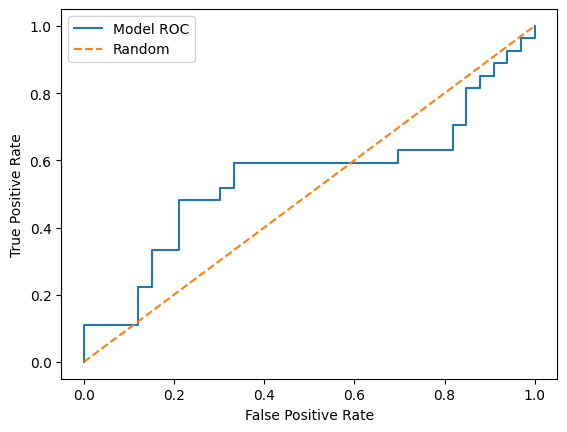

In [31]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipe_svm, X, y,
    cv=cv,
    scoring=["roc_auc", "f1"],
    return_train_score=False
)

{m: scores[m].mean() for m in scores if m.startswith("test_")}


{'test_roc_auc': np.float64(0.4434553872053872),
 'test_f1': np.float64(0.34910924654631753)}

In [33]:
# Get feature names after preprocessing
feature_names = []
if len(num_cols) > 0:
    feature_names += num_cols
feature_names += other_cols

coefs = pipe.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

coef_df.head(15)


,feature,coef,abs_coef
10,Lisch Nodules,-0.551906,0.551906
7,Café au lait (CLS),-0.534641,0.534641
3,Parental_Age_Gap,-0.517635,0.517635
16,Hypertension,-0.468758,0.468758
1,Age of Father,0.439157,0.439157
0,Age of Mother,-0.424492,0.424492
21,Early_Onset,-0.390027,0.390027
8,Axillary Freckles,0.325307,0.325307
20,Other Symptoms,-0.305208,0.305208
6,Tumour Case,0.301577,0.301577
